In [1]:
# from sklearn_pandas import DataFrameMapper, cross_val_score
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import helper
import sklearn.preprocessing, sklearn.decomposition, sklearn.linear_model, sklearn.pipeline, sklearn.metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA,TruncatedSVD
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.impute import SimpleImputer
import random

In [2]:
# =======================+=======================+=======================+=======================+
movies = pd.read_csv('./netflix-prize-data/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['movieId', 'Year', 'Name1', 'Name2', 'Name3', 'Name4'])
for ind, row in movies.iterrows():
    movies.loc[ind, ['title']] = ",".join([str(title) if (str(title) != "nan") else "" for title in movies.loc[ind, ['Name1', 'Name2', 'Name3', 'Name4']]]).rstrip(",")

movies.drop(labels=['Name1', 'Name2', 'Name3', 'Name4'], axis=1, inplace=True)
# movies.set_index('movieId', inplace = True)

Run below cell for preprocessing data or when running for the first time

In [3]:
# # Skip date
# df1 = pd.read_csv('./netflix-prize-data/combined_data_1.txt', header = None, names = ['userId','rating', 'Date'], usecols = [0,1, 2])
# df1['rating'] = df1['rating'].astype(float)

# ratings = df1
# # =======================+=======================+=======================+=======================+
# df_nan = pd.DataFrame(pd.isnull(ratings.rating))
# df_nan = df_nan[df_nan['rating'] == True]
# df_nan = df_nan.reset_index()

# movie_np = []
# movieId = 1
# movie_titles = []


# for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):

#     temp = np.full((1,i-j-1), movieId)\
#     movie_np = np.append(movie_np, temp)
#     movieId += 1

# last_record = np.full((1,len(ratings) - df_nan.iloc[-1, 0] - 1),movieId)
# movie_np = np.append(movie_np, last_record)
# ratings = ratings[pd.notnull(ratings['rating'])]

# ratings['movieId'] = movie_np.astype(int)
# ratings['userId'] = ratings['userId'].astype(int)
# print('-Dataset examples-')
# print(ratings.iloc[::5000000, :])
# # =======================+=======================+=======================+=======================+
# ratings.to_csv("./netflix-prize-data/pre-processed/user_movie_rating.csv", index=False)

In [4]:
ratings = pd.read_csv('./netflix-prize-data/pre-processed/user_movie_rating.csv', low_memory=False)

In [5]:
ratings.head()

,userId,rating,Date,movieId
0,1488844,3.0,2005-09-06,1
1,822109,5.0,2005-05-13,1
2,885013,4.0,2005-10-19,1
3,30878,4.0,2005-12-26,1
4,823519,3.0,2004-05-03,1


In [6]:
movies_percentile = 0.7
#Movies rate count percentile
#I will leave only movies on the (1-movies_percentile) percentile with respect to movies rating count

customers_percentile = 0.7
#Customers rate count percentile
#I will leave only customers on the (1-customers_percentile) percentile with respect to customers rating count


df_movie_summary = ratings.groupby('movieId')['rating'].agg(['count'])
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(movies_percentile),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

df_cust_summary = ratings.groupby('userId')['rating'].agg(['count'])
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(customers_percentile),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Movies minimum rating count: {}'.format(movie_benchmark))
print('Customers minimum rating count: {}'.format(cust_benchmark))

print('Original Shape: {}'.format(ratings.shape))
ratings = ratings[~ratings['movieId'].isin(drop_movie_list)]
ratings = ratings[~ratings['userId'].isin(drop_cust_list)]

print('After Trim Shape: {}'.format(ratings.shape))

print('unique movies left:')
print(ratings['movieId'].unique().size)
print('unique customers left:')
print(ratings['userId'].unique().size)

Movies minimum rating count: 1799.0
Customers minimum rating count: 52.0
Original Shape: (24053764, 4)
After Trim Shape: (17337458, 4)
unique movies left:
1350
unique customers left:
143458


In [7]:
# df_p = pd.pivot_table(df,values='rating',index='userId',columns='movieId')
# df_p = df_p.fillna(0)
# print(df_p.head(10))

In [8]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (143458, 1342) 

Subset example:


title,10,10 Things I Hate About You,101 Dalmatians II: Patch's London Adventure,11:14,13 Ghosts,18 Again,1984,2 Fast 2 Furious,200 Cigarettes,2010: The Year We Make Contact
userId,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
79,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = helper.get_most_rated_movies(user_movie_ratings, 1000)
# most_rated_movies_1k = helper.get_most_rated_movies(user_movie_ratings, 1000)

/Users/venkataramanabalajirajendran/Documents/Venkat/MS/Spring2022/SML/project/helper.py:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


To have sklearn run k-means clustering to a dataset with missing values like this, we will first cast it to the sparse csr matrix type defined in the SciPi library.

To convert from a pandas dataframe to a sparse matrix, we'll have to convert to SparseDataFrame, then use pandas' to_coo() method for the conversion.

Note: to_coo() was only added in later versions of pandas. If you run into an error with the next cell, make sure pandas is up to date.

In [10]:
# most_rated_movies_1k.describe()
# np.isnan(sparse_ratings)

In [11]:
# sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())
# sparse_ratings = csr_matrix(most_rated_movies_1k.values)
sparse_df = most_rated_movies_1k.astype(pd.SparseDtype("float64",fill_value=0))
# sparse_df = user_movie_ratings.astype(pd.SparseDtype("float64",fill_value=0))
# sparse_ratings = csr_matrix(sparse_df.sparse.to_coo())
# sparse_ratings = pd.DataFrame.sparse.from_spmatrix(sparse_df)

In [12]:
sparse_ratings = csr_matrix(sparse_df.sparse.to_coo())

In [13]:
sparse_ratings.data[np.isnan(sparse_ratings.data)] = 0.0

In [15]:
svd = TruncatedSVD(n_components=600)
sparse_ratings_reduced = svd.fit_transform(sparse_ratings)

## Let's cluster!

With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20 (A better way to pick k is as illustrated above with the elbow method. That would take some processing time to run, however.):

In [26]:
# 35 clusters
predictions = KMeans(n_clusters=35, algorithm='full').fit_predict(sparse_ratings_reduced)

# Custom Start

In [27]:
np.savetxt("./preds/kmeans_preds_35.txt", predictions.astype(int), fmt="%i")

# Custom END

To visualize some of these clusters, we'll plot each cluster as a heat map:

In [28]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# clustered = pd.concat([user_movie_ratings.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
# helper.draw_movie_clusters(clustered, max_users, max_movies)

## Prediction

Let's pick a cluster and a specific user and see what useful things this clustering will allow us to do.

Let's first pick a cluster:

In [ ]:
# Find User => 
# TODO: Pick a cluster ID from the clusters above
userId = 1488844
# cluster_number = 7

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
for cluster_number in range(35):
    if userId in clus
    cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
    cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

/Users/venkataramanabalajirajendran/Documents/Venkat/MS/Spring2022/SML/project/helper.py:169: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


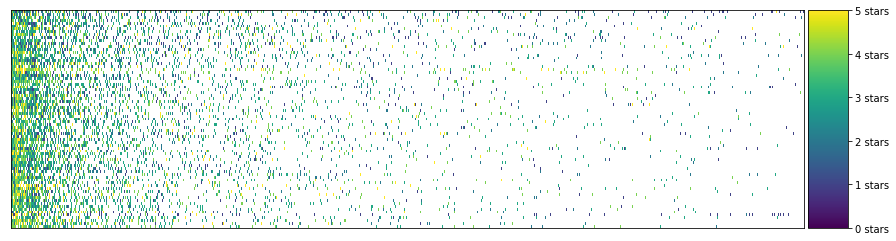

In [29]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = 7

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = helper.sort_by_rating_density(cluster, n_movies, n_users)
helper.draw_movies_heatmap(cluster, axis_labels=False)

And the actual ratings in the cluster look like this:

In [30]:
cluster.fillna('').head()

,Pirates of the Caribbean: The Curse of the Black Pearl,Lord of the Rings: The Fellowship of the Ring,The Italian Job,The Last Samurai,American Beauty,Bruce Almighty,The Bourne Supremacy,The Sixth Sense,Kill Bill: Vol. 2,Shrek 2,...,The Prime of Miss Jean Brodie,Highlander: Season 5,Father's Little Dividend,The Computer Wore Tennis Shoes,The Hunchback of Notre Dame,Missing in Action 2: The Beginning / Missing in Action 3: Braddock,The Love Letter,Richie Rich,Holiday in the Sun,Police Academy 5: Assignment - Miami Beach
348,4.0,4.0,4.0,5.0,3.0,3.0,4.0,1.0,4.0,1.0,...,,5.0,1.0,,,,,1.0,,
4447,3.0,1.0,2.0,5.0,5.0,2.0,2.0,4.0,2.0,2.0,...,,,,,,,,,,
6495,3.0,,3.0,2.0,3.0,3.0,3.0,,3.0,2.0,...,,,,,2.0,,,,,
2104,4.0,,4.0,4.0,4.0,,3.0,3.0,5.0,,...,,,,,,,,,,
236,2.0,4.0,,3.0,5.0,,4.0,3.0,4.0,4.0,...,,,,,,,,,,


Pick a blank cell from the table. It's blank because that user did not rate that movie. Can we predict whether she would like it or not? Since the user is in a cluster of users that seem to have similar taste, we can take the average of the votes for that movie in this cluster, and that would be a reasonable predicition for much she would enjoy the film.

In [31]:
# TODO: Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
# Pick a movie from the table above since we're looking at a subset
movie_name = "Bruce Almighty"

cluster[movie_name].mean()

2.8524590163934427

And this would be our prediction for how she'd rate the movie.

## Recommendation

Let's reiterate what we did in the previous step. We have used k-means to cluster users according to their ratings. This lead us to clusters of users with similar ratings and thus generally a similar taste in movies. Based on this, when one user did not have a rating for a certain movie we averaged the ratings of all the other users in the cluster, and that was our guess to how this one user would like the movie.

Using this logic, if we calculate the average score in this cluster for every movie, we'd have an understanding for how this 'taste cluster' feels about each movie in the dataset.

In [24]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

American Beauty                                           4.205479
The Silence of the Lambs                                  4.351351
The Sixth Sense                                           4.166667
Pirates of the Caribbean: The Curse of the Black Pearl    3.513889
Jaws                                                      4.260274
Being John Malkovich                                      3.816901
Moonstruck                                                3.671233
Lord of the Rings: The Fellowship of the Ring             4.071429
The Full Monty                                            3.700000
Braveheart                                                3.750000
A Beautiful Mind                                          3.777778
The Wizard of Oz: Collector's Edition                     4.297297
When Harry Met Sally                                      3.555556
Ghost                                                     2.971831
Bridget Jones's Diary                                     3.43

This becomes really useful for us because we can now use it as a recommendation engine that enables our users to discover movies they're likely to enjoy.

When a user logs in to our app, we can now show them recommendations that are appropriate to their taste. The formula for these recommendations is to select the cluster's highest-rated movies that the user did not rate yet.

In [25]:
# TODO: Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 1700

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Jaws                                            4.260274
Lost: Season 1                                  4.250000
Six Feet Under: Season 4                        4.241379
Absolutely Fabulous: Series 5                   4.240000
The Simpsons: Season 6                          4.222222
The Third Man                                   4.133333
Nip/Tuck: Season 2                              4.105263
The Simpsons: Season 1                          4.071429
The Simpsons: Treehouse of Horror               4.051282
The Simpsons: Season 3                          4.023810
End of the Century: The Story of the Ramones    4.000000
Batman Begins                                   3.978723
The Looney Tunes Golden Collection: Vol. 2      3.956522
Foyle's War: Set 2                              3.950000
The Simpsons: Bart Wars                         3.933333
The Twilight Zone: Vol. 33                      3.916667
The West Wing: Season 3                         3.903226
Buffy the Vampire Slayer: Seaso